In [32]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

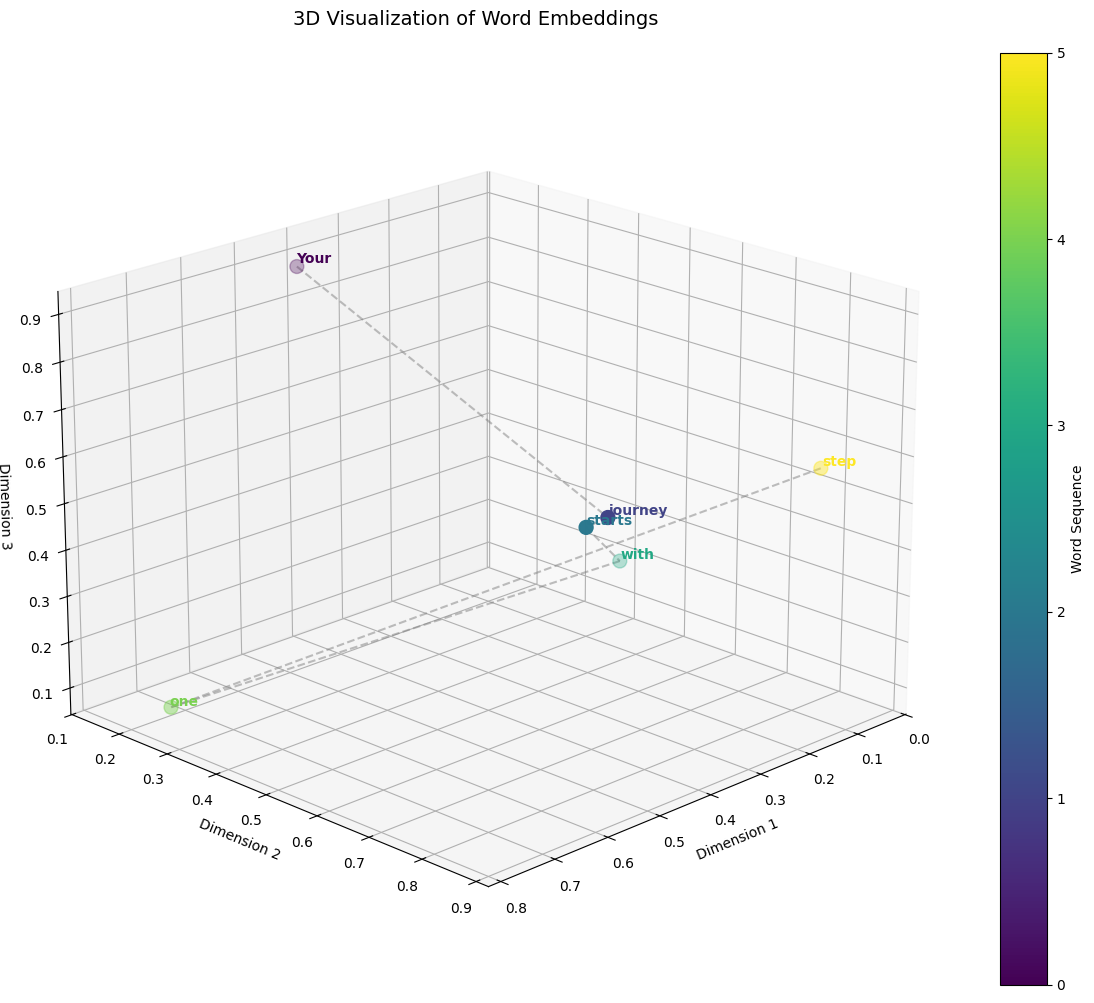

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import numpy as np

# Extract x, y and z coordinates from the tensor
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D scatter plot with larger figure size
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a colormap for sequential data using get_cmap
try:
    cmap = plt.get_cmap('viridis')
except:
    cmap = plt.get_cmap('jet')  # fallback colormap
colors = cmap(np.linspace(0, 1, len(x_coords)))

# Plot scatter points with larger markers and colors
scatter = ax.scatter(x_coords, y_coords, z_coords, 
                    c=range(len(x_coords)), 
                    cmap=cmap,
                    s=100)  # Larger point size

# Add connecting lines between sequential points
for i in range(len(x_coords)-1):
    ax.plot([x_coords[i], x_coords[i+1]], 
            [y_coords[i], y_coords[i+1]], 
            [z_coords[i], z_coords[i+1]], 
            color='gray', 
            linestyle='--', 
            alpha=0.5)

# Add labels for each point with consistent offset and matching colors
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']
for i, word in enumerate(words):
    ax.text(x_coords[i] + 0.02, 
            y_coords[i] + 0.02, 
            z_coords[i] + 0.02, 
            word,
            color=colors[i],
            fontweight='bold')

# Customize the plot
ax.set_title('3D Visualization of Word Embeddings', 
             fontsize=14, 
             pad=20)

# Set axis labels using the proper method for 3D axes
ax.xaxis.set_label_text('Dimension 1')
ax.yaxis.set_label_text('Dimension 2')
ax.zaxis.set_label_text('Dimension 3')

# Add grid for better spatial perception
ax.grid(True)

# Add colorbar to show sequence
plt.colorbar(scatter, label='Word Sequence')

# Adjust the viewing angle for better perspective
ax.view_init(elev=20, azim=45)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()

In [34]:
## how do we calculate the attention score?

## by using dot product between the query and other vectors 

In [35]:
query = inputs[1]  # journey

# Calculating the attention score
attention_scores_2 = torch.empty(inputs.shape[0])

for i,x_i in enumerate(inputs):
    attention_scores_2[i] = torch.dot(query,x_i)

print(attention_scores_2)

# Vectorized attention score calculation

print(f"inputs shape: {inputs.shape} and query shape: {query.shape}")

attention_scores = torch.matmul(inputs, query)
print("\nVectorized calculation:")
print(attention_scores)

# Verify they give the same results
print("\nBoth methods give same results:", 
      torch.allclose(attention_scores, attention_scores_2))



tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
inputs shape: torch.Size([6, 3]) and query shape: torch.Size([3])

Vectorized calculation:
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])

Both methods give same results: True


In [36]:
## normalization

attention_scores_2_softmax = torch.softmax(attention_scores_2,dim=0)

print(attention_scores_2_softmax)

print(attention_scores_2_softmax.sum() == 1)

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
tensor(True)


### How is a context vector calculated for a query?

After calculating the attention scores, we take each embedding vector and scale it by it's attention score wrt the query and then sum them up and the resulting vector we have is the context vector for the query.

Basically it's a enriched vector for the query 

By enriched , I mean that initally the embedding vectors contained information about itself but this enriched vector contains information about itself wrt all the other words in the sentence, i.e. It has enriched meaning of itself wrt the whole sentence.

# ![context](context.png)


In [37]:
embeeding_scaled_with_attenton_scores = attention_scores_2_softmax.unsqueeze(-1) * inputs

print(f"s1: {attention_scores_2_softmax.shape} and s2: {inputs.shape}")

print(embeeding_scaled_with_attenton_scores)

context_vector_for_query = torch.sum(embeeding_scaled_with_attenton_scores,dim=0)

print(f"enriched context_vector_for_query: {context_vector_for_query}")

s1: torch.Size([6]) and s2: torch.Size([6, 3])
tensor([[0.0596, 0.0208, 0.1233],
        [0.1308, 0.2070, 0.1570],
        [0.1330, 0.1983, 0.1493],
        [0.0273, 0.0719, 0.0409],
        [0.0833, 0.0270, 0.0108],
        [0.0079, 0.1265, 0.0870]])
enriched context_vector_for_query: tensor([0.4419, 0.6515, 0.5683])


Above i did for a single query, now let's do it for all the queries together 
like how it happens and utilze the vectorization to make it efficient

In [38]:
attention_scores_matrix = torch.matmul(inputs,inputs.T)

print(f"attention_scores_matrix: \n {attention_scores_matrix}")

attention_scores_matrix_softmax = torch.softmax(attention_scores_matrix,dim=1)

print(f"attention_scores_matrix_softmax : \n {attention_scores_matrix_softmax}")

attention_scores_matrix: 
 tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])
attention_scores_matrix_softmax : 
 tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [40]:
## now we will calculate the context vector for all the queries together


embedding_vectors_scaled_with_attention_scores = attention_scores_matrix_softmax.unsqueeze(-1) * inputs.unsqueeze(0)

print(f"shape of embedding_vectors_scaled_with_attention_scores: {embedding_vectors_scaled_with_attention_scores.shape}")

## now to get the context vector for all queries just sum up the scaled vectors 

context_vetors_for_all_queries = torch.sum(embedding_vectors_scaled_with_attention_scores,dim=1)

print(f"context_vetors_for_all_queries: \n {context_vetors_for_all_queries}")

print(f"shape of context_vetors_for_all_queries: {context_vetors_for_all_queries.shape}")



shape of embedding_vectors_scaled_with_attention_scores: torch.Size([6, 6, 3])
context_vetors_for_all_queries: 
 tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])
shape of context_vetors_for_all_queries: torch.Size([6, 3])


In [44]:
## what a dumbo man, it can be done in a single line of code
## but it's hard to visualize the matrix multiplication

print(f"attention_scores_2_softmax shape: {attention_scores_matrix_softmax.shape}")
print(f"inputs shape: {inputs.shape}")

context_vectors_for_all_queries = attention_scores_matrix_softmax @ inputs



print(f"context_vectors_for_all_queries: \n {context_vectors_for_all_queries}")


attention_scores_2_softmax shape: torch.Size([6, 6])
inputs shape: torch.Size([6, 3])
context_vectors_for_all_queries: 
 tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


##### on that note , want to remember another mental model for visualizing the matrix multiplication

so let's say we have A(6,6) and B(6,4)

the we can say that the result of mat mul is :

taking a selected row of A:

each value along columns of selected row of A is first scaling the corresponding row of B 
(i.e. for a given selected row of A, ith column of A is scaling the ith row of B
 and after that summing up all the scaled rows together)

and that scaled and summed up value is the value of the selected row of the result matrix 

for example:

let's say we have a matrix A(3,3) and B(3,2)

A [[1,2,3],
   [4,5,6],
   [7,8,9]]

B [[1,2],
   [3,4],
   [5,6]]

output matrix row 1 is:

A row 1 [1,2,3]

scale each value of B by the corresponding value of A row 1

scaled B:
1 * [1,2] = [1,2] 
2 * [3,4] = [6,8]
3 * [5,6] = [15,18]

now sum up all the scaled rows together

[22,28]

output matrix row 1 is:

A row 2 [4,5,6]


In [45]:
## let's verify this mental model

A = torch.tensor([[1,2,3],
                 [4,5,6],
                 [7,8,9]])

B = torch.tensor([[1,2],
                 [3,4],
                 [5,6]])

output = A @ B

print(f"output: \n {output}")

output: 
 tensor([[ 22,  28],
        [ 49,  64],
        [ 76, 100]])


In [46]:
## Phew Phew, I'm glad I got that right